## Further analysis of time-series analysis, after the milestone 1.

## Introduction & Executive summary

In this section, we implemented further analysis of time-series analysis after the milestone 1. First, we considered and implemented how we can obtain the stationarity of data. Then, we applied ARIMA model to cryptocurrencies to make the prediction of future price of cryptocurrencies. To optimize the (p, d, q) parameters of ARIMA model, we took two different approaches that are introduced in the tutorial, that is, 1. Graphical method and 2. Grid-search. Finally, we visualize our prediction in the graph. While our prediction took very wide in range, for example, it could capture the current price surge of bitcoin.

## Setup for colab and libraries

In [1]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/IT5006/FinalPackage'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/IT5006/FinalPackage']


In [2]:
#Install necessary libraries
!pip install pandas

In [3]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.9MB/s 
     |████████████████████████████████| 9.5MB 32.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import time
import pandas_datareader.data as web
import math
import itertools
#handling date
from datetime import datetime

#import libraries for time-series analysis
from statsmodels import api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pylab
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller

#import libraries for ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
#For data checking purpuse such as head(), tail(),
#just changed max disaplay row to 100 rows
pd.set_option('display.max_rows', 100)

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Checking data stationarity for cryptos.

### Data acquisition

In [7]:
# By following the financial market convention, we take until 4 decimal points.
pd.options.display.float_format = '{:.4f}'.format

In [8]:
main_df = pd.read_csv("./team12_cleandata.csv")
del main_df['Unnamed: 0']
main_df.head()

,day,btc_price,btc_mktcap,btc_volume,eth_price,eth_mktcap,eth_volume,xrp_price,xrp_mktcap,xrp_volume,ltc_price,ltc_mktcap,ltc_volume,btc_price_chg,btc_mktcap_chg,btc_volume_chg,eth_price_chg,eth_mktcap_chg,eth_volume_chg,xrp_price_chg,xrp_mktcap_chg,xrp_volume_chg,ltc_price_chg,ltc_mktcap_chg,ltc_volume_chg,btc_vol20d,eth_vol20d,xrp_vol20d,ltc_vol20d,btc_vol60d,eth_vol60d,xrp_vol60d,ltc_vol60d,btc_SMA10d,eth_SMA10d,xrp_SMA10d,ltc_SMA10d,btc_SMA50d,eth_SMA50d,xrp_SMA50d,...,spx_SMA50d,ndx_SMA50d,gold_SMA50d,us10y_SMA50d,dxy_SMA50d,spx_SMA100d,ndx_SMA100d,gold_SMA100d,us10y_SMA100d,dxy_SMA100d,spx_SMA200d,ndx_SMA200d,gold_SMA200d,us10y_SMA200d,dxy_SMA200d,spx_DiffSMA10d,ndx_DiffSMA10d,gold_DiffSMA10d,us10y_DiffSMA10d,dxy_DiffSMA10d,spx_DiffSMA50d,ndx_DiffSMA50d,gold_DiffSMA50d,us10y_DiffSMA50d,dxy_DiffSMA50d,spx_DiffSMA100d,ndx_DiffSMA100d,gold_DiffSMA100d,us10y_DiffSMA100d,dxy_DiffSMA100d,spx_DiffSMA200d,ndx_DiffSMA200d,gold_DiffSMA200d,us10y_DiffSMA200d,dxy_DiffSMA200d,spx_RSI,ndx_RSI,gold_RSI,us10y_RSI,dxy_RSI
0,2013-04-28,135.3000,1500517590.0000,0.0000,nan,nan,nan,nan,nan,nan,4.2998,73773387.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1554.4250,2797.0750,1545.0000,1.8590,82.5992,1523.0785,2767.9025,1597.4525,1.9042,81.4073,nan,nan,nan,nan,nan,0.0096,0.0108,0.0325,-0.0139,-0.0026,0.0142,0.0119,-0.0476,-0.0855,-0.0014,0.0351,0.0226,-0.0788,-0.1072,0.0132,nan,nan,nan,nan,nan,56.7657,55.7151,45.5074,35.5147,48.3449
1,2013-04-29,141.9600,1575032004.0000,0.0000,nan,nan,nan,nan,nan,nan,4.3594,74936909.0000,0.0000,0.0492,0.0497,nan,nan,nan,nan,nan,nan,nan,0.0139,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1555.8600,2799.2800,1542.7050,1.8558,82.5960,1524.4135,2769.1075,1595.1900,1.9026,81.4303,nan,nan,nan,nan,nan,0.0144,0.0178,0.0243,-0.0122,-0.0060,0.0208,0.0213,-0.0487,-0.0840,-0.0054,0.0419,0.0325,-0.0800,-0.1065,0.0088,nan,nan,nan,nan,nan,60.8551,60.6802,44.5890,35.5147,42.8319
2,2013-04-30,135.3000,1501657493.0000,0.0000,nan,nan,nan,nan,nan,nan,4.1829,72037636.0000,0.0000,-0.0469,-0.0466,nan,nan,nan,nan,nan,nan,nan,-0.0405,-0.0387,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1557.3900,2801.9500,1540.4400,1.8526,82.5844,1525.8060,2770.6700,1593.0850,1.9004,81.4433,nan,nan,nan,nan,nan,0.0138,0.0212,0.0200,-0.0111,-0.0101,0.0229,0.0287,-0.0464,-0.0824,-0.0103,0.0440,0.0403,-0.0779,-0.1055,0.0035,nan,nan,nan,nan,nan,62.4033,64.2059,45.0369,35.5147,37.0423
3,2013-05-01,117.0000,1298951550.0000,0.0000,nan,nan,nan,nan,nan,nan,3.6491,62957992.0000,0.0000,-0.1353,-0.1350,nan,nan,nan,nan,nan,nan,nan,-0.1276,-0.1260,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1558.4500,2804.0800,1538.0500,1.8482,82.5728,1527.0265,2772.2300,1591.1525,1.8977,81.4547,nan,nan,nan,nan,nan,0.0033,0.0129,0.0066,-0.0304,-0.0099,0.0137,0.0232,-0.0542,-0.1018,-0.0113,0.0345,0.0349,-0.0857,-0.1253,0.0023,nan,nan,nan,nan,nan,55.7765,60.8569,41.5966,30.1364,35.9218
4,2013-05-02,103.4300,1148667722.0000,0.0000,nan,nan,nan,nan,nan,nan,3.3888,58565340.0000,0.0000,-0.1160,-0.1157,nan,nan,nan,nan,nan,nan,nan,-0.0713,-0.0698,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1559.5100,2806.1150,1535.8400,1.8434,82.5752,1528.3695,2774.1200,1589.3650,1.8950,81.4718,nan,nan,nan,nan,nan,0.0082,0.0198,0.0122,-0.0264,-0.0024,0.0208,0.0342,-0.0434,-0.0995,-0.0044,0.0416,0.0461,-0.0756,-0.1240,0.0091,nan,nan,nan,nan,nan,60.0052,65.6610,46.1078,30.1364,46.8811


In [9]:
#Extract price data for cryptos and day.
crypto_price_df = main_df[['day','btc_price', 'eth_price', 'xrp_price', 'ltc_price']]
#set day as index
crypto_price_df['day'] = crypto_price_df['day'].astype("datetime64")  
crypto_price_df = crypto_price_df.set_index('day')
#set time frequency as Day = 'D' for executing time series analysis.
crypto_price_df = crypto_price_df.asfreq('D')
#Eliminate nan and fill previous day's price if nan.
crypto_price_df = crypto_price_df.fillna(method='ffill')

In [10]:
crypto_price_df.tail()

,btc_price,eth_price,xrp_price,ltc_price
day,,,,
2020-12-27,26476.1301,636.7423,0.2954,129.7577
2020-12-28,26423.2288,689.6599,0.2841,127.8991
2020-12-29,27125.3841,732.9570,0.2461,130.6387
2020-12-30,27424.5390,735.5909,0.2214,129.6282
2020-12-31,28837.2885,752.8559,0.2121,129.2442


### Checking stationarity for all cryptos.

We checked how we can obtain the data stationarity for all cryptocurrencies of btc, eth, xrp, and ltc, in terms of following ways:

*  Additive decomposition and taking residual.
*  Multiplicative decomposition and taking residual.
*  Taking log of data, then impliment additive decomposition.
*  Differencing by raw data.
*  Differencing by log taken data.
*  Taking daily price % change.

For inspection methodologies, we applied ADF test and graphical method.

Key take-aways are as follows. Probably, those results stem from the historical data properties of cryptocurrencies which surged the price exponentially.

*  In total, additive decomposition and differencing on raw data don't work well, by looking at graphs.

*  Totally, below 3 are good to obtain stationarity data: 
1. Residuals on multiplicative decomposition
2. Residuals on additive decomposition after taking Log
3. differencing of log data.

*  % change of raw data is very simple, but it doesn't look so bad by looking at graphs. Also, in btc, ADF test shows very good results. 

ADF and p-valuec results for btc


,adfStatistic,pValue
AdditiveResid,-12.6736,0.000000000000000000000012295773
MultiResid,-13.7664,0.000000000000000000000000098663
LogAddResid,-14.1858,0.000000000000000000000000018938
RawDiff,-8.5975,0.000000000000070132333927812521
LogDiff,-10.6026,0.000000000000000000611604645155
PctChange,-15.1909,0.000000000000000000000000000601


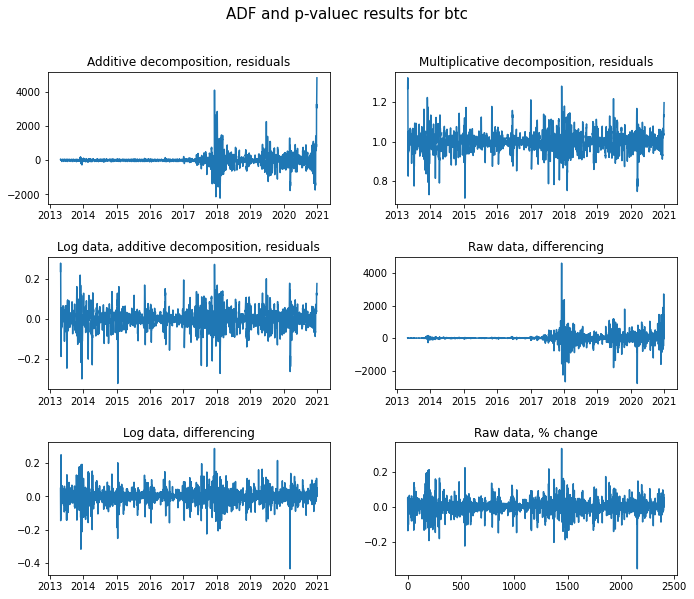

ADF and p-valuec results for eth


,adfStatistic,pValue
AdditiveResid,-9.9284,0.000000000000000028658376632493
MultiResid,-21.0131,0.000000000000000000000000000000
LogAddResid,-15.7084,0.000000000000000000000000000137
RawDiff,-7.4535,0.000000000055901180513122433822
LogDiff,-28.2936,0.000000000000000000000000000000
PctChange,-7.8816,0.000000000004688165570213051345


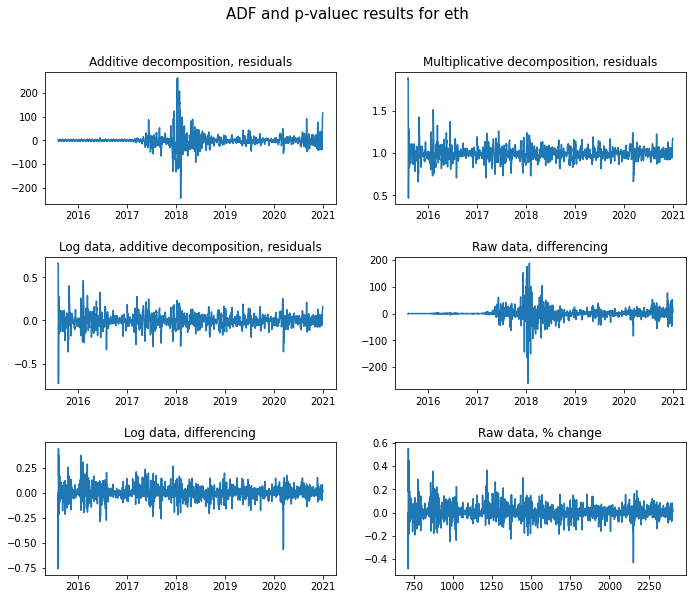

ADF and p-valuec results for xrp


,adfStatistic,pValue
AdditiveResid,-14.5364,0.000000000000000000000000005231
MultiResid,-15.6104,0.000000000000000000000000000178
LogAddResid,-13.5286,0.000000000000000000000000264844
RawDiff,-11.4011,0.000000000000000000007645057564
LogDiff,-14.2731,0.000000000000000000000000013635
PctChange,-13.7684,0.000000000000000000000000097841


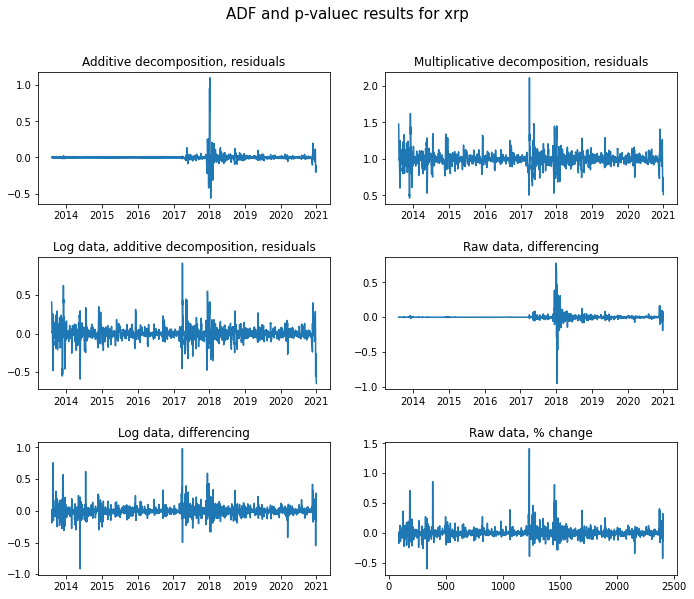

ADF and p-valuec results for ltc


,adfStatistic,pValue
AdditiveResid,-14.3130,0.000000000000000000000000011758
MultiResid,-13.1942,0.000000000000000000000001128134
LogAddResid,-15.0015,0.000000000000000000000000001088
RawDiff,-9.4516,0.000000000000000459957861897344
LogDiff,-17.5228,0.000000000000000000000000000004
PctChange,-7.7263,0.000000000011563954019714626601


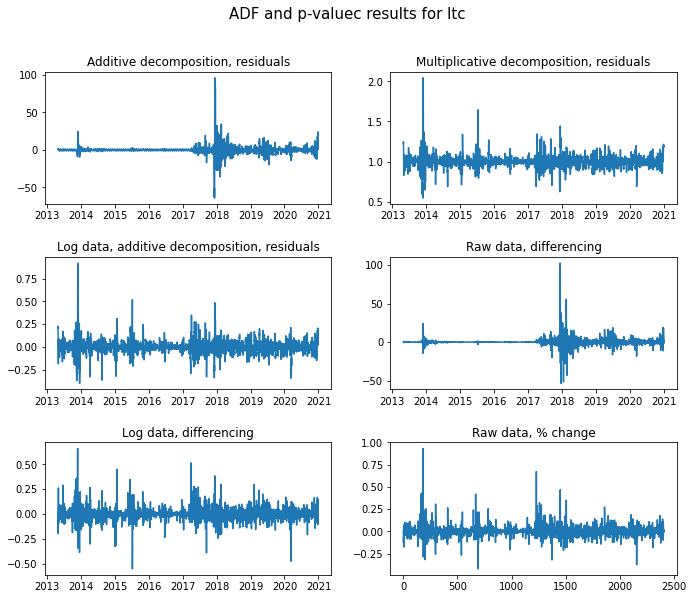

In [11]:
cryptos = ['btc', 'eth', 'xrp', 'ltc']

for crypto in cryptos:
  price_column = crypto + str('_price')
  pctchg_column = crypto + str('_price_chg')

  #additive, residual
  crypto_result_add = seasonal_decompose(crypto_price_df[price_column].dropna(), model='additive',
                              extrapolate_trend='freq', freq=20)
  crypto_add_adfresult = adfuller(crypto_result_add.resid.dropna(), autolag='AIC')

  #multiplicative, residual
  crypto_result_mul = seasonal_decompose(crypto_price_df[price_column].dropna(), model='multiplicative',
                              extrapolate_trend='freq', freq=20)
  crypto_mul_adfresult = adfuller(crypto_result_mul.resid.dropna(), autolag='AIC')

  #taking log of data, then additive
  crypto_log = np.log(crypto_price_df[price_column])
  crypto_log_add = seasonal_decompose(crypto_log.dropna(), model="additive",extrapolate_trend='freq', freq=20)
  crypto_log_adf = adfuller(crypto_log_add.resid.dropna(), autolag='AIC')

  #Raw data, differencing
  crypto_diff_adf = adfuller(crypto_price_df[price_column].diff().dropna(), autolag='AIC')

  #Log data, differencing
  crypto_log_diff_adf = adfuller(crypto_log.diff().dropna(), autolag='AIC')

  #Price % Change
  price_chg_adf = adfuller(main_df[pctchg_column].dropna(), autolag='AIC')

  #Creating dataframe for the results
  indexs = ["AdditiveResid","MultiResid","LogAddResid","RawDiff","LogDiff",
            "PctChange"]
  columns = ["adfStatistic", "pValue"]
  data = [
          [crypto_add_adfresult[0],crypto_add_adfresult[1]],
          [crypto_mul_adfresult[0],crypto_mul_adfresult[1]],
          [crypto_log_adf[0],crypto_log_adf[1]],
          [crypto_diff_adf[0],crypto_diff_adf[1]],
          [crypto_log_diff_adf[0],crypto_log_diff_adf[1]],
          [price_chg_adf[0],price_chg_adf[1]]
  ]
  adfresults_df = pd.DataFrame(data,columns=columns, index = indexs)
  adfresults_df['pValue'] = adfresults_df['pValue'].apply(lambda x: '%.30f' % x) 

  print("ADF and p-valuec results for " + str(crypto))
  display(adfresults_df)

  #showing graphs
  fig, axes = plt.subplots(3, 2, figsize=(10, 8))
  fig.suptitle("ADF and p-valuec results for " + str(crypto),fontsize=15, y=1.05)

  axes[0, 0].plot(crypto_result_add.resid)
  axes[0, 0].set_title("Additive decomposition, residuals")

  axes[0, 1].plot(crypto_result_mul.resid)
  axes[0, 1].set_title("Multiplicative decomposition, residuals")

  axes[1, 0].plot(crypto_log_add.resid)
  axes[1, 0].set_title("Log data, additive decomposition, residuals")

  axes[1, 1].plot(crypto_price_df[price_column].diff())
  axes[1, 1].set_title("Raw data, differencing")

  axes[2, 0].plot(crypto_log.diff())
  axes[2, 0].set_title("Log data, differencing")

  axes[2, 1].plot(main_df[pctchg_column])
  axes[2, 1].set_title("Raw data, % change")

  plt.tight_layout(pad=2.0)
  plt.show()

## Applying ARIMA model

As we can see the above results, differencing of log data can serve stationarity relatively well for all cryptos, such that we convert raw price data into log then apply ARIMA model. 

To optimize the (p, d, q) parameters of ARIMA model, we took two different approaches that are introduced in the tutorial, that is, 1. Graphical method by ACF and PACF, and 2. Grid-search. 

We implemented with both methods, and reached to the best model of bitcoin prediction as ARIMA(10,1,10) by graphical methods and ARIMA(5,1,5) by grid-search method.

In [12]:
#Taking log data for all cryptcurrencies.
crypto_logprice_df = np.log(crypto_price_df)

In [13]:
crypto_price_df.tail()

,btc_price,eth_price,xrp_price,ltc_price
day,,,,
2020-12-27,26476.1301,636.7423,0.2954,129.7577
2020-12-28,26423.2288,689.6599,0.2841,127.8991
2020-12-29,27125.3841,732.9570,0.2461,130.6387
2020-12-30,27424.5390,735.5909,0.2214,129.6282
2020-12-31,28837.2885,752.8559,0.2121,129.2442


In [14]:
crypto_logprice_df.tail()

,btc_price,eth_price,xrp_price,ltc_price
day,,,,
2020-12-27,10.1840,6.4564,-1.2195,4.8657
2020-12-28,10.1820,6.5362,-1.2583,4.8512
2020-12-29,10.2082,6.5971,-1.4019,4.8724
2020-12-30,10.2192,6.6007,-1.5078,4.8647
2020-12-31,10.2694,6.6239,-1.5508,4.8617


### Graphical method

First, we optimized parameters (p,d,q) of ARIMA model by graphically seeing ACF and PACF.

#### Confirming d, by checking difference graphically.

As we tried both first and second order differencing, 1st order of differencing was enough to obtain stationarity data. Therefore, we applied d=1.

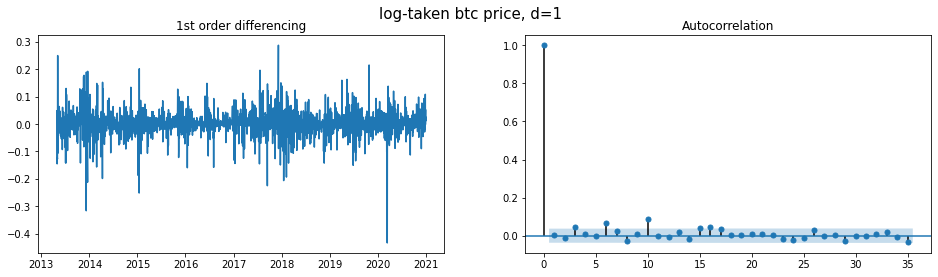

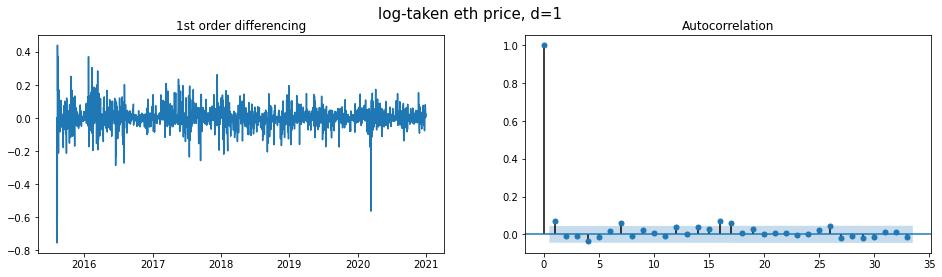

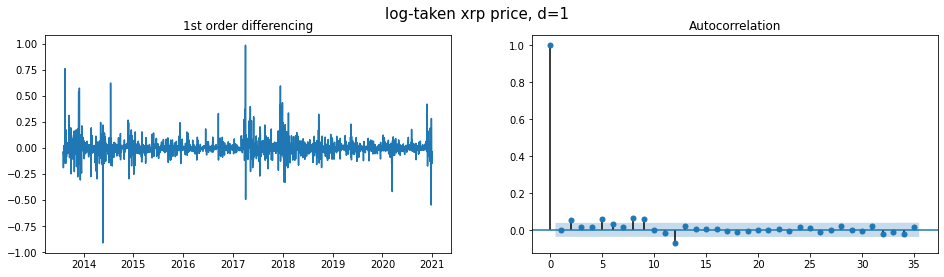

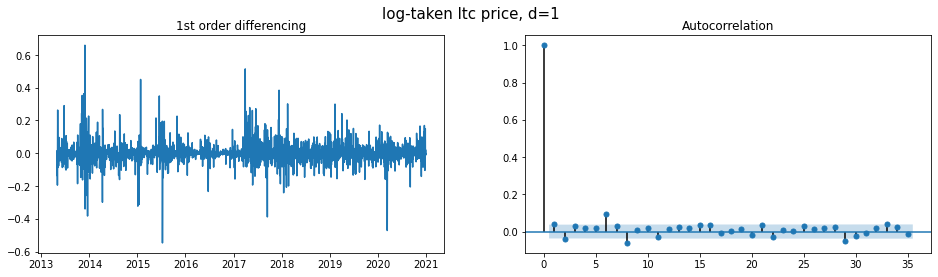

In [15]:
#1st order differencing (d=1)
crypt_list = ['btc', 'eth', 'xrp', 'ltc']

for crypt in crypt_list:
  diff = crypto_logprice_df[crypt + '_price'].diff().dropna()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
  fig.suptitle('log-taken {0} price, d=1'.format(crypt),fontsize=15)
  ax1.plot(diff)
  ax1.set_title('1st order differencing')
  plot_acf(diff, ax=ax2)

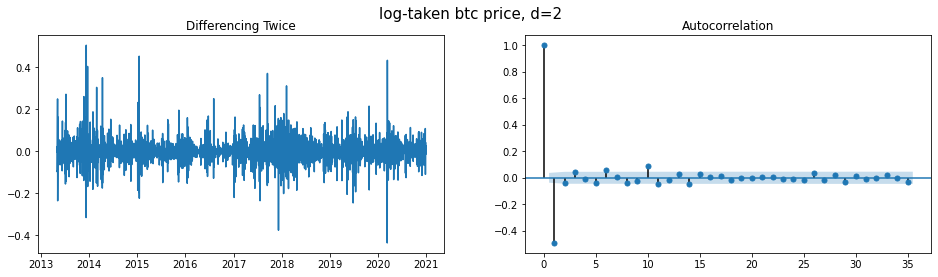

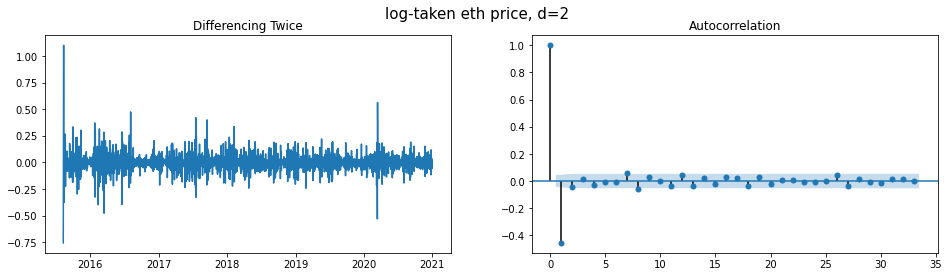

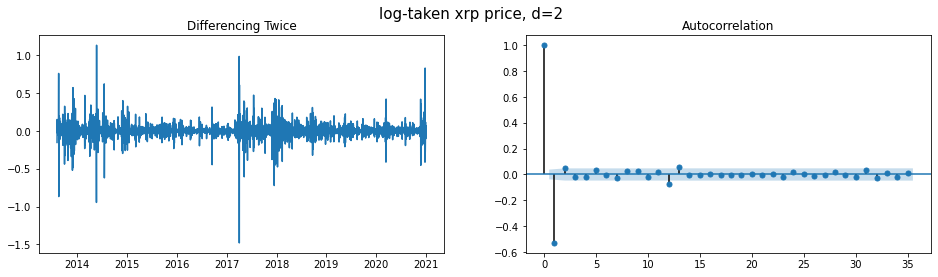

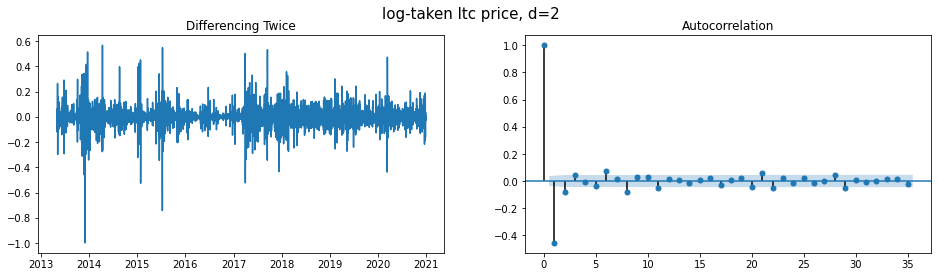

In [16]:
#2nd order differencing (d=2)
crypt_list = ['btc', 'eth', 'xrp', 'ltc']

for crypt in crypt_list:
  diff = crypto_logprice_df[crypt + '_price'].diff().diff().dropna()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
  fig.suptitle('log-taken {0} price, d=2'.format(crypt),fontsize=15)
  ax1.plot(diff)
  ax1.set_title('Differencing Twice')
  plot_acf(diff, ax=ax2)

#### Confirming p by checking PACF graph, and q by checking ACF.

From our observation of PACF and ACF graphically, below results can be obtained.

*  btc: p=6,10, q=6,10 looking good.
*  eth: p=1,7, q=1,7 looking good.
*  xrp: p=2,5,8,9, q=2,5,8,9 looking good.
*  ltc: p=6, q=6 looking good.


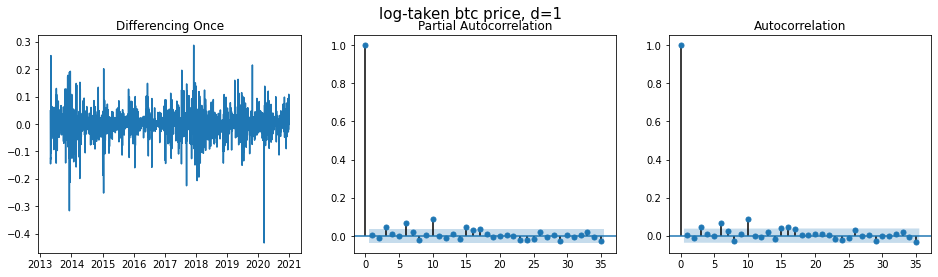

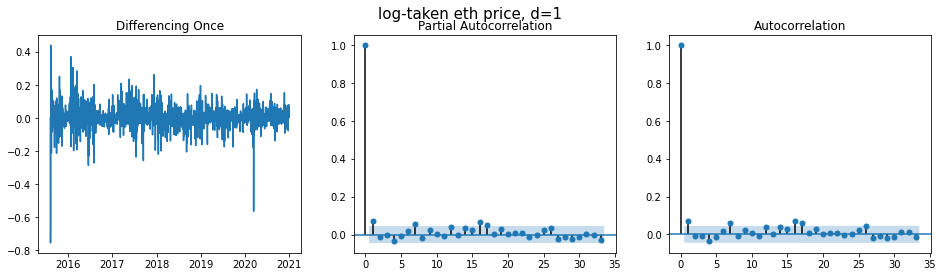

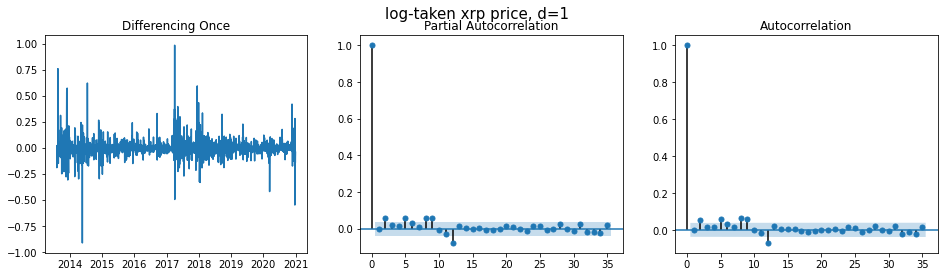

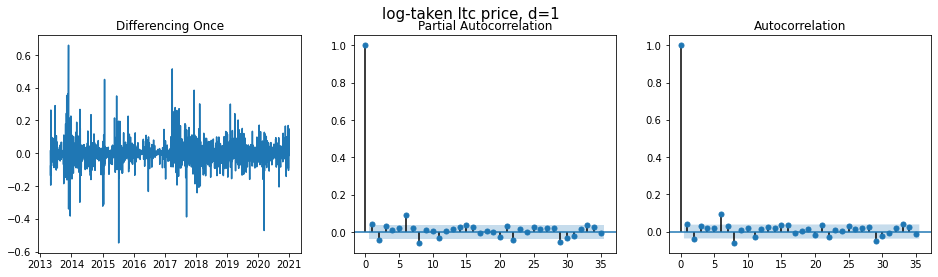

In [17]:
crypt_list = ['btc', 'eth', 'xrp', 'ltc']

for crypt in crypt_list:
  diff = crypto_logprice_df[crypt + '_price'].diff().dropna()

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
  fig.suptitle('log-taken {0} price, d=1'.format(crypt),fontsize=15)
  ax1.plot(diff)
  ax1.set_title('Differencing Once')
  plot_pacf(diff, ax=ax2)
  plot_acf(diff, ax=ax3)

#### Developing ARIMA model.

Based on above results, we tried to create btc pricing model by ARIMA(10,1,10). We prepared class to handle whole process of ARIMA modeling.

In [18]:
class ARIMAModeling:

  def __init__(self, data):
    #Just take price data and then convert it tinto log.
    self.data = data
    self.crypto_log = np.log(self.data)

    #Setting list for grid search.
    #p > 5, operation becomes slow. If you'd like to finish faster, pls change here.
    self.plist = [1,2,3,4,5,6,7,8,9,10]
    #regarding differencing, 1 is enough to obtain stationarity,
    #from our previous investigation of stationarity.
    self.dlist = [1]
    #if q > 5, operation becomes very slow. If you'd like to finish faster, pls change here.
    self.qlist = [1,2,3,4,5,6,7,8,9,10]

  #function to calculate errors
  def forecast_accuracy(self, forecast, actual):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE - Mean absolute percentage error
      me = np.mean(forecast - actual)             # ME - mean error
      mae = np.mean(np.abs(forecast - actual))    # MAE - mean absolute error
      mpe = np.mean((forecast - actual)/actual)   # MPE - mean percentage error
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      corr = np.corrcoef(forecast, actual)[0,1]   # corr
      errors ={'mape':mape, 'me':me, 'mae': mae, 
              'mpe': mpe, 'rmse':rmse, 'corr':corr}
      return errors

  #Apply ARIMA(p,d,q) and return accuracy measurements such as 
  #aic, bic, rmse etc.
  def arimaFitting(self, trainsplit, errormeasure, p,d,q):
    #train test split
    train_num = int(len(self.crypto_log) * trainsplit)
    test_num = len(self.crypto_log) - train_num
    self.train, self.test = self.crypto_log[:train_num], self.crypto_log[train_num:]
    #apply ARIMA(p,d,q)
    self.model = ARIMA(self.train, order=(p,d,q))
    self.fitted = self.model.fit(disp=-1)
    #take forecast
    self.fc, self.se, self.conf = self.fitted.forecast(test_num, alpha=0.05)
    #return errors
    errors = self.forecast_accuracy(self.fc, self.test.values)
    #return aic
    model_aic = self.fitted.aic
    #return bic
    model_bic = self.fitted.bic

    if errormeasure == 'aic':
      #utilize aic as measurement of model goodness
      accuracy_measurement = model_aic
    elif errormeasure == 'bic':
      #utilize aic as measurement of model goodness
      accuracy_measurement = model_bic
    else:
      #utilize error as measurement of accuracy
      accuracy_measurement = errors[errormeasure]
    
    return accuracy_measurement

  #Gridsearching the model
  def gridSearchARIMA(self, trainsplit, errormeasure):
    
    best_score, best_pdq = float("inf"), None 
    for params in itertools.product(self.plist, self.dlist, self.qlist):
      try:
        accuracy_measure = self.arimaFitting(trainsplit, errormeasure,
                                            params[0],params[1],params[2])
      except:
        continue
      print('ARIMA Model(' + str(params[0]) + ',' +str(params[1]) +','
      +str(params[2]) + ') by ' + errormeasure + ' : ' + str(accuracy_measure))

      if accuracy_measure < best_score:
        best_score, best_pdq = accuracy_measure, params

    print('The Best model is ARIMA(' + str(best_pdq[0]) + ',' +str(best_pdq[1]) +','
    +str(best_pdq[2]) + ') by ' + errormeasure + ' : ' + str(best_score))

    self.arimaFitting(trainsplit, errormeasure, best_pdq[0],best_pdq[1],best_pdq[2])

    return best_score, best_pdq

  #showing summary
  def summaryShow(self):
    print(self.fitted.summary())

  #showing residual plot and histogram
  def residualGraph(self):
    residuals = pd.DataFrame(self.fitted.resid, columns=['residual'])
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title="Density", ax=ax[1])
    plt.tight_layout()
    plt.show()

  #Showing graph of the model
  #To convert back log-taken prices to actual price, just taking np.exp() of log-taken data.
  def graphShow(self):
    fc_series = pd.Series(np.exp(self.fc), index=self.test.index)
    se_series = pd.Series(np.exp(self.se), index=self.test.index)
    lower_series = pd.Series(np.exp(self.conf[:,0]), index=self.test.index)
    upper_series = pd.Series(np.exp(self.conf[:,1]), index=self.test.index)

    plt.figure(figsize=(12,5))
    plt.plot(np.exp(self.train), label='training')
    plt.plot(np.exp(self.test), label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)
    plt.title("Forecast vs Actual")
    plt.xlabel("Day")
    plt.ylabel("Cryptocurrency price")
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [19]:
btcARIMA = ARIMAModeling(crypto_price_df['btc_price'])

Implementing ARIMA(10,1,10) for btc. Train/test split is set as 90/10 this time. (Note: It can take about 4-5 mins)

In [20]:
btcARIMA.arimaFitting(trainsplit=0.90, errormeasure='aic', p=10,d=1,q=10)

-8835.071802313527

Data visualization. Residuals show data stationarity with bell curve distribution by taking KDE. By reversing log data into real price data by taking np.exp(), we can see our prediction too. While our prediction takes very wide in range, it can capture nowaday's price surge of bitcoin.

In [21]:
btcARIMA.summaryShow()

                             ARIMA Model Results                              
Dep. Variable:            D.btc_price   No. Observations:                 2523
Model:               ARIMA(10, 1, 10)   Log Likelihood                4439.536
Method:                       css-mle   S.D. of innovations              0.042
Date:                Wed, 21 Apr 2021   AIC                          -8835.072
Time:                        11:17:01   BIC                          -8706.741
Sample:                    04-29-2013   HQIC                         -8788.503
                         - 03-25-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0015      0.001      1.612      0.107      -0.000       0.003
ar.L1.D.btc_price     -0.2485      0.528     -0.470      0.638      -1.284       0.787
ar.L2.D.btc_price   

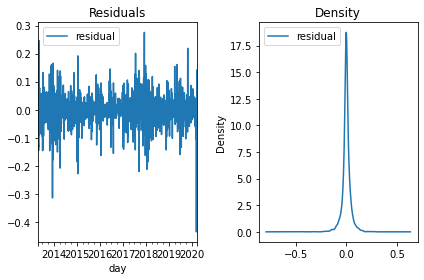

In [22]:
btcARIMA.residualGraph()

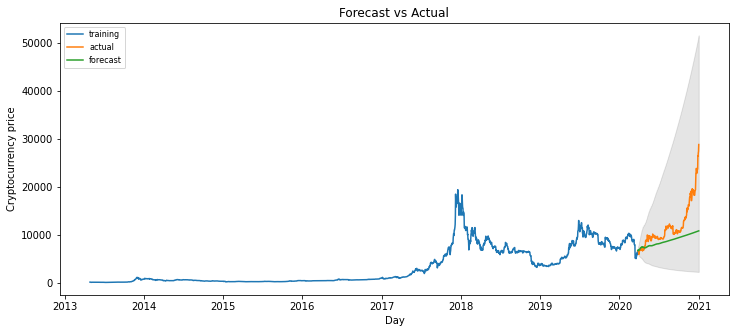

In [23]:
btcARIMA.graphShow()

### Grid-serch method

In this section, we tried to obtain the best combination of (p, d, q) by grid-search. It is grid-search, such that it can take long time to obtain whole results (For around 1 hour). For model selection, we applied AIC. For details, please refer following web-site too.

https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/

https://otexts.com/fpp2/arima-estimation.html


In [24]:
btcARIMA.gridSearchARIMA(trainsplit=0.9, errormeasure='aic')

ARIMA Model(1,1,1) by aic : -8809.38837259368
ARIMA Model(1,1,3) by aic : -8817.986805542867
ARIMA Model(1,1,4) by aic : -8811.428996713847
ARIMA Model(1,1,5) by aic : -8809.716134535749
ARIMA Model(1,1,6) by aic : -8817.452190835356
ARIMA Model(1,1,7) by aic : -8815.77459028659
ARIMA Model(1,1,8) by aic : -8814.506943386561
ARIMA Model(1,1,9) by aic : -8815.876067132092
ARIMA Model(1,1,10) by aic : -8832.258331094385
ARIMA Model(2,1,3) by aic : -8816.591484881512
ARIMA Model(2,1,4) by aic : -8814.756247970676
ARIMA Model(2,1,5) by aic : -8809.54411325587
ARIMA Model(2,1,6) by aic : -8808.05400389939
ARIMA Model(2,1,7) by aic : -8816.923778525474
ARIMA Model(2,1,8) by aic : -8818.821106781204
ARIMA Model(2,1,9) by aic : -8833.324905754907
ARIMA Model(2,1,10) by aic : -8831.012499402685
ARIMA Model(3,1,1) by aic : -8818.05487908328
ARIMA Model(3,1,2) by aic : -8821.183697537941
ARIMA Model(3,1,3) by aic : -8828.764959683518
ARIMA Model(3,1,4) by aic : -8828.872877004149
ARIMA Model(3,1,

(-8843.374136310122, (5, 1, 5))

From grid-search of bitcoin, the best ARIMA model was ARIMA(5,1,5). Again, while our prediction takes very wide in range, it can capture nowaday's price surge of bitcoin. With regard to other cryptocurrencies such as eth, xrp, ltc, we can create the forcast using exactly same methodology.

In [25]:
#Fitting the best ARIMA model from grid-search.
btcARIMA.arimaFitting(trainsplit=0.90, errormeasure='aic', p=5,d=1,q=5)

-8843.374136310122

In [26]:
btcARIMA.summaryShow()

                             ARIMA Model Results                              
Dep. Variable:            D.btc_price   No. Observations:                 2523
Model:                 ARIMA(5, 1, 5)   Log Likelihood                4433.687
Method:                       css-mle   S.D. of innovations              0.042
Date:                Wed, 21 Apr 2021   AIC                          -8843.374
Time:                        12:41:13   BIC                          -8773.376
Sample:                    04-29-2013   HQIC                         -8817.973
                         - 03-25-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0015      0.001      1.367      0.172      -0.001       0.004
ar.L1.D.btc_price     1.1042      0.097     11.343      0.000       0.913       1.295
ar.L2.D.btc_price    -1.

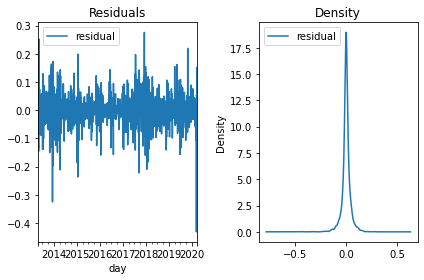

In [27]:
btcARIMA.residualGraph()

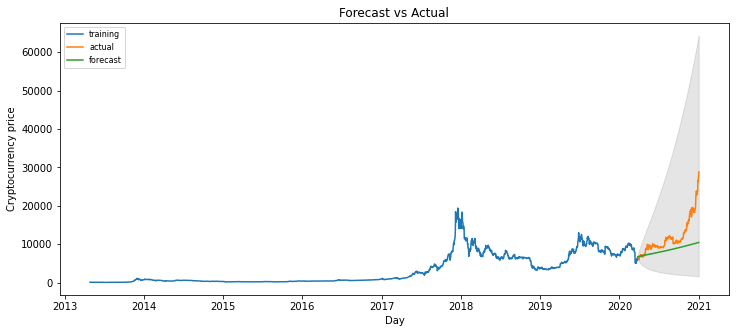

In [28]:
btcARIMA.graphShow()

## Conclusion

Conclusion from further time-series analysis after the milestone 1 is as follows:

Regarding the stationarity of data, key take-aways are as follows. Probably, those results stem from the historical data properties of cryptocurrencies which surged the price exponentially.

*  In total, additive decomposition and differencing on raw data don't work well, by looking at graphs.

*  Totally, below 3 are good to obtain stationarity data: 
1. Residuals on multiplicative decomposition
2. Residuals on additive decomposition after taking Log
3. differencing of log data.

*  % change of raw data is very simple, but it doesn't look so bad by looking at graphs. Also, in btc, ADF test shows very good results. 

As we can see the above results, differencing of log data can serve stationarity relatively well for all cryptos, such that we convert raw price data into log then apply ARIMA model. 

To optimize the (p, d, q) parameters of ARIMA model, we took two different approaches that are introduced in the tutorial, that is, 1. Graphical method by ACF and PACF, and 2. Grid-search. 

We implemented with both methods, and reached to the best model of bitcoin prediction as ARIMA(10,1,10) by graphical methods and ARIMA(5,1,5) by grid-search method. While our prediction takes very wide in range, it can capture nowaday's price surge of bitcoin. With regard to another currencies such as eth, xrp, ltc, we can build ARIMA predicting model in a same way.